In [1]:
SAVE_NAME = 'noFt_2'

In [2]:
import os
import sys
import math
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Helper function
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()

# Normalize usr_genre
def ugNorm(usr_genre):
    usr_genre_norm = np.zeros(usr_genre.shape)
    for i in range(len(usr_genre)):
        usr_genre_norm[i] = usr_genre[i]/np.max(usr_genre[i])
    print(usr_genre_norm.shape)
    return usr_genre_norm

def relu(x):
    return np.maximum(0,x)  

def softmax(x):
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x 

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Load numpy array

In [4]:
def train_test_split(usr_following):
    #The number of following movie for each user
    each_user = np.sum(usr_following, axis=1)
    # print(each_user)

    print('Min number of followings:', np.min(each_user))
    print('Max number of followings:', np.max(each_user))
    print('Avg of followers:', np.mean(each_user))
    
    usr_idx = [i for i in range(len(usr_following))]
    print(len(usr_idx))

    random.seed(42)
    test_idx = sorted(random.sample(usr_idx, usr_test_amount))
    print(len(test_idx), test_idx[:10]) # 150 [13, 51, 54, 61, 65, 88, 93, 96, 114, 130]

    # init
    train_t = []
    train_f = []
    test_t = []
    test_f = []

    for i in range(usr_nb):
        # init
        t_for_train = []
        f_for_train = []
        t_for_test = []
        f_for_test = []

        if i not in test_idx: #if not in test id, just append it to true or false list
            for j in range(movie_nb):
                if usr_following[i][j] == 1:
                    t_for_train.append(j)
                else:
                    f_for_train.append(j)

            train_t.append(t_for_train)
            train_f.append(f_for_train)
    #         print(len(t_for_train) + len(f_for_train))

        else: #if in test id, choose half of true and other 
            temp_t = []
            temp_f = []

            for j in range(movie_nb):
                if usr_following[i][j] == 1:
                    temp_t.append(j)
                else:
                    temp_f.append(j)

            # random choose half true and half false for test 
            t_for_test = random.sample(temp_t, math.ceil(0.5*len(temp_t)))
            f_for_test  = random.sample(temp_f, movie_test_amount-len(t_for_test))

            test_t.append(t_for_test)
            test_f.append(f_for_test)

            #the others for training
            t_for_train = [item for item in temp_t if not item in t_for_test]
            f_for_train = [item for item in temp_f if not item in f_for_test]
            train_t.append(t_for_train)
            train_f.append(f_for_train)

        if not (len(t_for_train) + len(f_for_train) + len(t_for_test) + len(f_for_test)) == movie_nb:
            print('Error!!!')
            break
    
    return train_t, train_f, test_t, test_f, test_idx

In [5]:
# Basic setup
usr_following = np.load('./npy/user_followings.npy')
usr_genre = np.load('./npy/user_genre.npy')
movie_genre = np.load('./npy/movie_genre.npy')

print('Movie genre:', movie_genre.shape)
print('User following:', usr_following.shape)
print('User genre:', usr_genre.shape)

usr_nb = len(usr_following) # the number of users
movie_nb = len(movie_genre)  # the number of movies
print(usr_nb, movie_nb)

usr_test_amount = 150
movie_test_amount = 32
print(usr_test_amount, movie_test_amount)

latent_dim = 64 # latent dims
ft_dim = 2372
embedding_dims = 240
print(latent_dim, ft_dim, embedding_dims)

usr_genre_norm = ugNorm(usr_genre)
train_t, train_f, test_t, test_f, test_idx = train_test_split(usr_following)

# Stat
#average num of following for training user
total_train = 0
for t in train_t:
    total_train += len(t)
avg = total_train / usr_nb
print('Training:', avg)

#average num of following for testing user
total_test = 0
for t in test_t:
    total_test += len(t)
avg = total_test / usr_test_amount
print('Testing:', avg)

all_auxilary = [i for i in range(movie_nb)]

Movie genre: (165, 20)
User following: (1582, 165)
User genre: (1582, 20)
1582 165
150 32
64 2372 240
(1582, 20)
Min number of followings: 10
Max number of followings: 133
Avg of followers: 14.820480404551201
1582
150 [13, 51, 54, 61, 65, 88, 93, 96, 114, 130]
Training: 14.139064475347661
Testing: 7.1866666666666665


In [6]:
def training(SAVE_NAME):
    print('==================================================')
    print(SAVE_NAME)
    print('Start time:', time.ctime())

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    loss_acc_list = []
    t0 = time.time()

    train_yes_id=[]

    for q in range(6):
        print('Epoch:',q)
        train_auc = 0
        total_loss = 0
        xuij_auc = 0
        length = 0

        for z in range(usr_nb):
            writeProgress('Progress:', z, usr_nb)
            """
            yes 用來存放選擇到的YouTuber feature (for auxilary)
            yesr 用來存放user對該YouTuber的喜好程度(user_category 跟 YouTuber_category的相似性)
            r_3 用來存放user 對該YouTuber種類的偏好(取max)
            """
            yesr = []

    #         #選全部的Positive
    #         sample = random.sample(train_t[z],len(train_t[z]))
            #選全部的電影
            sample = all_auxilary

            #change
            r_3 = np.zeros(len(sample))

            for b in range(len(sample)):
                yesr.append(movie_genre[sample[b]] * usr_genre_norm[z])

            for b in range(len(yesr)):
                r_3[b]=max(yesr[b])
            #print('r_3:',r_3)

            # positive sample
            train_t_sample = train_t[z]
            for ta in train_t_sample:
                #print(ta,'--> positive feedback')

                pos = sample.index(ta)

#                 image_1=np.expand_dims(all_npy[ta],0)
                train_f_sample = random.sample(train_f[z],10)

                for b in train_f_sample:
                    _a_list, r3, _auc, _loss, _ = sess.run(
                        [a_list_smooth, a_list_soft, auc, loss, train_op],
                        feed_dict={user: [z], i: [ta], j: [b],
                                   l_id:sample, l_id_len:[len(sample)],
                                   positive_id: train_t[z], positive_len:[len(train_t[z])], r: r_3})

                    train_auc += _auc
                    total_loss += _loss
                    length += 1

        print("{:<20}{}".format('total_loss', total_loss/length))
        print("{:<20}{}".format('train_auc:', train_auc/length))

        loss_acc_list.append([total_loss/length, train_auc/length])

        print('\tCurrent time:', time.ctime(), ' sec')
        print('==================================================')

    print('Total cost time:',time.time()-t0, ' sec')

    print('End time:', time.ctime())
    
    U, Y, A, Au, Ay, Aa = sess.run([user_latent, item_latent, aux_item, Wu, Wy, Wa])
    np.savez('./weight/mask1ft/' + SAVE_NAME + '.npz',
             U=U, Y=Y, A=A, Wu=Au, Wy=Ay, Wa=Aa)
    
    return loss_acc_list

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
noFt_2
Start time: Fri May 29 13:26:00 2020
Epoch: 0
total_loss          [[0.59448941]]
train_auc:          0.7499508226037196
	Current time: Fri May 29 15:32:08 2020  sec
Epoch: 1
total_loss          [[0.59112558]]
train_auc:          0.7634209585121602
	Current time: Fri May 29 17:38:14 2020  sec
Epoch: 2
total_loss          [[0.59224834]]
train_auc:          0.7641586194563662
	Current time: Fri May 29 19:44:15 2020  sec
Epoch: 3
total_loss          [[0.59220503]]
train_auc:          0.7638993204577968
	Current time: Fri May 29 21:50:31 2020  sec
Epoch: 4
total_loss          [[0.5935538

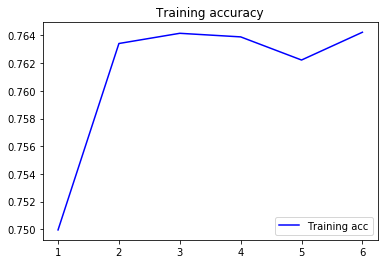

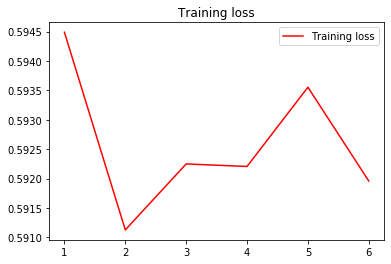

In [7]:
tf.reset_default_graph()

user = tf.placeholder(tf.int32,shape=(1,))
i = tf.placeholder(tf.int32, shape=(1,))
j = tf.placeholder(tf.int32, shape=(1,))

#多少個auxliary 
xf = tf.placeholder(tf.float32, shape=(None, ft_dim))
l_id = tf.placeholder(tf.int32, shape=(None,))
l_id_len = tf.placeholder(tf.int32,shape=(1,))
r = tf.placeholder(tf.float32,shape=(None,))
positive_id = tf.placeholder(tf.int32, shape=(None,))
positive_len = tf.placeholder(tf.int32,shape=(1,))

image_i = tf.placeholder(tf.float32, [1, ft_dim])
image_j = tf.placeholder(tf.float32, [1, ft_dim])

with tf.variable_scope("item_level"):
    user_latent = tf.get_variable("user_latent", [usr_nb, latent_dim],
                                  initializer=tf.random_normal_initializer(0,0.1,seed=3))
    item_latent = tf.get_variable("item_latent", [movie_nb, latent_dim],
                                  initializer=tf.random_normal_initializer(0,0.1,seed=3)) 
    aux_item = tf.get_variable("aux_item", [movie_nb, latent_dim],
                               initializer=tf.random_normal_initializer(0,0.1,seed=3))

#     W1 = tf.get_variable("W1", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
    Wu = tf.get_variable("Wu", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
    Wy = tf.get_variable("Wy", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
    Wa = tf.get_variable("Wa", [usr_nb, movie_nb, latent_dim], initializer=tf.contrib.layers.xavier_initializer())
    aux_new = tf.get_variable("aux_new", [1, latent_dim], initializer=tf.constant_initializer(0.0))

#lookup the latent factors by user and id
u = tf.nn.embedding_lookup(user_latent, user)
vi = tf.nn.embedding_lookup(item_latent, i)
vj = tf.nn.embedding_lookup(item_latent, j)

# w1 = tf.nn.embedding_lookup(W1, user)
wu = tf.squeeze(tf.nn.embedding_lookup(Wu, user))
wy = tf.squeeze(tf.nn.embedding_lookup(Wy, user))
wa = tf.squeeze(tf.nn.embedding_lookup(Wa, user))

a_list = tf.Variable([])
q = tf.constant(0)

def att_cond(q,a_list):
    return tf.less(q,l_id_len[0])

def att_body(q,a_list):
    xfi = tf.expand_dims(xf[q],0) #(1,l)
    wuui = tf.expand_dims(tf.nn.embedding_lookup(wu,l_id[q]),0) #取該YOUTUBER那欄(1,K)
    wyui = tf.expand_dims(tf.nn.embedding_lookup(wy,l_id[q]),0) #取該YOUTUBER那欄(1,K)
    waui = tf.expand_dims(tf.nn.embedding_lookup(wa,l_id[q]),0) #取該YOUTUBER那欄(1,K)

    a_list = tf.concat([a_list,[(tf.nn.relu(tf.matmul(wuui, u, transpose_b=True) +
                                            tf.matmul(wyui, tf.expand_dims(tf.nn.embedding_lookup(item_latent,l_id[q]),0), transpose_b=True) +
                                            tf.matmul(waui, tf.expand_dims(tf.nn.embedding_lookup(aux_item, l_id[q]),0), transpose_b=True))[0][0])*r[q]]],0)
    q += 1
    return q, a_list

_, a_list = tf.while_loop(att_cond,att_body,[q,a_list],shape_invariants=[q.get_shape(),tf.TensorShape([None])])

a_list_smooth = tf.add(a_list,0.0000000001)
a_list_soft = tf.divide(a_list_smooth,tf.reduce_sum(a_list_smooth, 0)) #without softmax

aux_np = tf.expand_dims(tf.zeros(latent_dim),0)
q = tf.constant(0)

def sum_att_cond(q,aux_np):
    return tf.less(q,l_id_len[0])

def sum_att_body(q,aux_np):
    aux_np = tf.math.add_n([aux_np,a_list_soft[q]*tf.expand_dims(tf.nn.embedding_lookup(aux_item, l_id[q]),0)]) 
    q += 1
    return q, aux_np

_, aux_np = tf.while_loop(sum_att_cond, sum_att_body, [q,aux_np])

aux_part = tf.matmul(aux_np, vi, transpose_b=True)
aux_np += u #user_latent factor + sum (alpha*auxilary)
aux_new = tf.assign(aux_new,aux_np) #把aux_new 的 值變成aux_np

#矩陣中對應函數各自相乘
# ex: tf.matmul(thetav,(tf.matmul(embedding, image_i, transpose_b=True)))
xui = tf.matmul(aux_new, vi, transpose_b=True)#+ tf.matmul(beta,(tf.matmul(embedding,image_i, transpose_b=True)))
xuj = tf.matmul(aux_new, vj, transpose_b=True)#+ tf.matmul(beta,(tf.matmul(embedding,image_j, transpose_b=True)))
xuij = tf.subtract(xui,xuj)

l2_norm = tf.add_n([
            0.0001 * tf.reduce_sum(tf.multiply(u, u)),
            0.0001 * tf.reduce_sum(tf.multiply(vi, vi)),
            0.0001 * tf.reduce_sum(tf.multiply(vj, vj)),

            0.01 * tf.reduce_sum(tf.multiply(wu, wu)),
            0.01 * tf.reduce_sum(tf.multiply(wy, wy)),
            0.01 * tf.reduce_sum(tf.multiply(wa, wa))
          ])

loss = l2_norm - tf.log(tf.sigmoid(xuij)) # objective funtion
train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss) #parameter optimize 
auc = tf.reduce_mean(tf.to_float(xuij > 0))

loss_acc_list = training(SAVE_NAME)

# training history
epochs = range(1, len(loss_acc_list) + 1)
print('Epoch:', epochs)
loss = [ls[0].tolist()[0][0] for ls in loss_acc_list]
print('Loss:', loss)
acc = [ls[1] for ls in loss_acc_list]
print('Acc:', acc)
print('==================================================')

plt.figure()
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()
#     print('==================================================')

# Testing Part
## Metrics

In [8]:
# Top N
def F1_score(prec,rec):
    f1 = 2*((prec*rec)/(prec+rec))
    return f1

def topN(RSls, n):
    maxn = np.argsort(RSls)[::-1][:n]
    return maxn

# NDCG
def allSortPrepare(testRS):
    all_sort = []

    for i in range(usr_test_amount):
        all_sort.append(topN(list(testRS[i]),len(testRS[i])))

    all_sort = np.asarray(all_sort)
    print(all_sort.shape)
    return all_sort

def DCG(prec_list): #找出前n名的[1,1,1,0,...]
    dcg = 0
    for i in range(len(prec_list)):
        dcg += (2**prec_list[i]-1)/math.log2(i+2)
    return dcg

def NDCG(target, testRS, num_ndcg, all_sort): #target是真正的喜好
    total_ndcg = 0
    
    for m in range(usr_test_amount): # the number of testing users
        idcg = DCG(target[m][:num_ndcg])
#         print('target[m][:num_ndcg]:\n', target[m][:num_ndcg])
        
        pre_list = []
        for s in all_sort[m][:num_ndcg]:
            #print(m,s,target[m][s])
#             print('target[m][:num_ndcg]:\n', target[m][:num_ndcg])
            pre_list.append(target[m][s]) #把prec_list 的 score加進去
#         print('pre_list:\n', pre_list)
        dcg = DCG(pre_list)
        ndcg = dcg/idcg
        total_ndcg += ndcg
        
    avg_ndcg = total_ndcg/usr_test_amount
    return avg_ndcg

# MAP
from sklearn.metrics import average_precision_score

def MAP(target,testRS):
    total_prec = 0
    for u in range(usr_test_amount):
        y_true = target[u]
        y_scores = testRS[u]
        total_prec += average_precision_score(y_true, y_scores)
        
    Map_value = total_prec/usr_test_amount
    
    return Map_value

In [9]:
def metrics(testRS, target, sumtarget, all_sort):
    # NDCG
    num_ndcgs = [10]
    for num_ndcg in num_ndcgs:
        print('NDCG@', num_ndcg)
        print('NDCG score:', NDCG(target, testRS, num_ndcg, all_sort))
        print('*****')

    print('\n==============================\n')

    # MAP
    print('MAP:', MAP(target,testRS))
    print('\n==============================\n')
    
    # Top N
    N = [1, 5]

    for n in N:
        print('Top', n)
        correct = 0

        for i in range(len(testRS)):
            topn = topN(testRS[i], n)
            sum_target = int(np.sum(target[i]))

            TP = 0
            for i in topn:
                if i < sum_target:
                    TP += 1

            correct += TP

        prec = correct/(len(testRS)*n) #150*n
        recall = correct/sumtarget

        print('prec:', prec)
        print('recall:', recall)
        print('F1_score:', F1_score(prec, recall))
        print('*****')

    print('\n==============================\n')

In [10]:
'''
usr_test_amount = 150
movie_test_amount = 32
'''
def testing(U, Y, A, Au, Ay, Aa):
    #with Embedding
    result = np.zeros((usr_test_amount, movie_nb))
    RS = np.zeros((usr_test_amount, movie_nb))

    #test_idx --> Test 的 index length = 150
    sum_alpha = 0

    for s in range(usr_test_amount):
#         print(s, test_idx[s])

        yes = []
        sample = train_t[test_idx[s]]
        alpha = np.zeros([len(sample)])

        for a in range(len(sample)):
            r = np.max(movie_genre[sample[a]] * usr_genre_norm[test_idx[s]]) #sample a 的category vec *user_category vec
            alpha_a = (np.dot(Au[test_idx[s]][sample[a]],np.expand_dims(U[test_idx[s]],0).T) + 
                       np.dot(Ay[test_idx[s]][sample[a]],np.expand_dims(Y[sample[a]],0).T) + 
                       np.dot(Aa[test_idx[s]][sample[a]],np.expand_dims(A[sample[a]],0).T))

            # relu part
            alpha[a]=np.sum((relu(alpha_a)))*r

        mul = np.zeros((1,latent_dim))
        added_alpha = np.add(alpha,0.0000000001) #np.add(np.maximum(alpha, 0),0.0000000001)
        norm_alpha = added_alpha/np.sum(added_alpha)
        sum_alpha += np.sum(alpha)

#         print("{:<15}{}".format('sum_alpha:', sum_alpha))
#         print('==================================================')

        for i in range(len(sample)):
            mul += norm_alpha[i] * A[sample[i]] # attention alpha*Ai part
        new_mul = mul + U[test_idx[s]]  #(U+auxilary)

        for k in range(movie_nb):
            result[s][k] = np.dot(new_mul,Y[k].T) #(U+auxilary)*photo latent factor
            RS[s][k] = np.dot(new_mul,Y[k].T)
        
    #取出test的資料
    print(RS.shape)

    testRS = np.zeros((usr_test_amount, movie_test_amount)) #shape 150 * 32
    target = np.zeros((usr_test_amount, movie_test_amount)) #shape 150 * 32

    for z in range(usr_test_amount):
        user_id = test_idx[z]
        # positive target YouTuber list
        youtube_t = test_t[z] 
        # not target YouTuber list
        youtube_f = test_f[z]

    #     print(user_id)
    #     print(youtube_t)
    #     print(youtube_f)

        #前面放target的RS
        for i in range(len(youtube_t)):
            testRS[z][i] = RS[z][youtube_t[i]]
            target[z][i] = 1

        for i in range(len(youtube_f)):
            testRS[z][i+len(youtube_t)] = RS[z][youtube_f[i]]

    #     print(testRS[z])
    #     print(target[z])
    #     print('==============================')

    print(target.shape, testRS.shape)
    sumtarget = np.sum(target)
    print('num of positive data in testing:', sumtarget) # whole matrix: 4800

    # for metrics
    metrics(testRS, target, sumtarget, allSortPrepare(testRS))

In [11]:
print(SAVE_NAME)

params = np.load('./weight/mask1ft/' + SAVE_NAME + '.npz')
#     print(params)
U = params['U']
Y = params['Y']
A = params['A']
Au = params['Wu']
Ay = params['Wy']
Aa = params['Wa']

print('User latent shape: ',U.shape)
print('photo latent shape: ', Y.shape)
print('Auxilary latent shape: ',A.shape)
print('Wu weight shape:', Au.shape)
print('Wy weight shape:', Ay.shape)
print('Wa weight shape:', Aa.shape)

testing(U, Y, A, Au, Ay, Aa)
print('==================================================')

noFt_2
User latent shape:  (1582, 64)
photo latent shape:  (165, 64)
Auxilary latent shape:  (165, 64)
Wu weight shape: (1582, 165, 64)
Wy weight shape: (1582, 165, 64)
Wa weight shape: (1582, 165, 64)
(150, 165)
(150, 32) (150, 32)
num of positive data in testing: 1078.0
(150, 32)
NDCG@ 10
NDCG score: 0.43959082419282786
*****


MAP: 0.43129506243680815


Top 1
prec: 0.37333333333333335
recall: 0.05194805194805195
F1_score: 0.09120521172638438
*****
Top 5
prec: 0.37333333333333335
recall: 0.2597402597402597
F1_score: 0.3063457330415755
*****


